In [1]:
# 1 import package
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.utils import save_image
from torchvision import transforms
import os
import matplotlib.pyplot as plt

/home/waj/anaconda3/envs/tts/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
BATCH_SIZE=512
EPOCHS=1000
image_size=28
channel=1
z_dim=128
device=torch.device("cuda")



# 1 data loader 

torch.Size([512, 1, 28, 28])


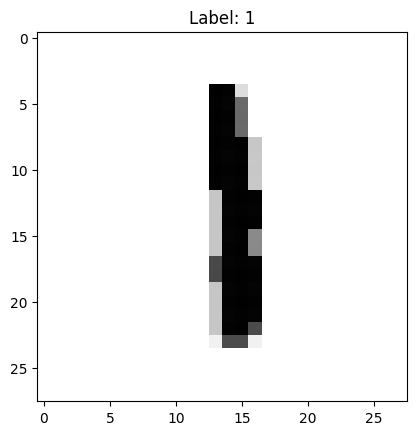

In [3]:
# 1 data loader 
dataset=datasets.MNIST("../data/",train=True,transform=transforms.Compose([
    transforms.Resize(28),transforms.ToTensor(),transforms.Normalize(0.5,0.5)
]))
mnist=DataLoader(dataset,shuffle=True,batch_size=BATCH_SIZE,drop_last=True)

def show_mnist_image(image_array, label):
    plt.imshow(image_array, cmap='Greys')
    plt.title(f"Label: {label}")
    
for data in mnist:
    print(data[0].shape)
    show_mnist_image(data[0][0][0], data[1][0])
    break

# 2 define Encoder Model

In [4]:
# encode  model
# input: image ,output :mean ,std

class Encoder(nn.Module):
    def __init__(self,z_dim):
        super(Encoder,self).__init__()
        self.model=nn.Sequential(
        nn.Linear(image_size*image_size,1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,z_dim),
            nn.ReLU(),
            nn.Linear(z_dim,2)
        )
    def forward(self,x):
        x=x.view(BATCH_SIZE,-1)
        y=self.model(x)
        return y
        

In [6]:
image_fake=torch.randn(BATCH_SIZE,channel,image_size,image_size)
print(image_fake.shape)
e_model=Encoder(z_dim)
z=e_model(image_fake)
z.shape

torch.Size([512, 1, 28, 28])


torch.Size([512, 2])

# 3 define Decder model

In [8]:
# decode model

class Decoder(nn.Module):
    def __init__(self,z_dim):
        super(Decoder,self).__init__()
        self.model=nn.Sequential(
            nn.Linear(z_dim,128),
            nn.ReLU(),
            nn.Linear(128,512),
            nn.ReLU(),
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024,image_size*image_size),
            nn.Tanh()
        )
    def forward(self,x):
        y=self.model(x)
        return y

In [12]:
test_x=torch.randn(BATCH_SIZE,z_dim)
print(test_x.shape)
d_model=Decoder(z_dim)
d_model(test_x).shape

torch.Size([512, 128])


torch.Size([512, 784])

# 4 Encoder and Decoder model

In [14]:
class EncoderDecoder(nn.Module):
    def __init__(self,z_dim):
        super(EncoderDecoder,self).__init__()
        self.encoder=Encoder(z_dim)
        self.decoder=Decoder(z_dim)
    def forward(self,x):
        z=self.encoder(x)
        mean=z[:,[0]]
        logvar=z[:,[1]]
        norm_std=torch.randn(BATCH_SIZE,z_dim).to(device)
        new_z=mean+norm_std*torch.exp(logvar*0.5)
        decoder_x=self.decoder(new_z)
        return decoder_x,mean,logvar

In [15]:
ed_model=EncoderDecoder(z_dim).to(device)
(gx,mean,logvar)=ed_model(image_fake.to(device))
print(gx.shape,mean.shape)

torch.Size([512, 784]) torch.Size([512, 1])


# 5 optimizer 

In [16]:
ed_optim=torch.optim.Adam(ed_model.parameters(),5e-5)


# 5 loss funciton 

In [17]:
# 1 reconstruction loss
loss_fn=nn.MSELoss()
# 2 KL loss

# 6 train

In [18]:
step=0
for epoch in range(EPOCHS):
    for data,label in mnist:
        x=data.to(device)
        (gx,mean,logvar)=ed_model(x)
        
        ed_optim.zero_grad()
        # rec loss
        rec_loss=loss_fn(x.reshape(BATCH_SIZE,-1),gx)
        # KL loss
        kl_loss=torch.mean(-0.5*(logvar+1-mean**2-torch.exp(logvar)))
        loss=rec_loss+kl_loss
        loss.backward()
        ed_optim.step()
        if step%200==0:
            print(f"epoch {epoch} ,step : {step} toral_Loss {loss} rec_loss {rec_loss} kl_loss : {kl_loss}")
            if step%200==0:
                os.makedirs("image",exist_ok=True)
                image=gx.reshape(BATCH_SIZE,1,28,28).data[:25]
                save_image(image,"image/%d.png" % step,normalize=True,nrow=5)
        step+=1

epoch 0 ,step : 0 toral_Loss 1.0567762851715088 rec_loss 1.0533273220062256 kl_loss : 0.0034489899408072233
epoch 1 ,step : 200 toral_Loss 0.2945965826511383 rec_loss 0.29406487941741943 kl_loss : 0.0005316918832249939
epoch 3 ,step : 400 toral_Loss 0.26976943016052246 rec_loss 0.265224426984787 kl_loss : 0.00454501248896122
epoch 5 ,step : 600 toral_Loss 0.2637917101383209 rec_loss 0.25476160645484924 kl_loss : 0.009030106477439404
epoch 6 ,step : 800 toral_Loss 0.2620556056499481 rec_loss 0.2533837854862213 kl_loss : 0.00867181085050106
epoch 8 ,step : 1000 toral_Loss 0.27019330859184265 rec_loss 0.26171672344207764 kl_loss : 0.008476595394313335
epoch 10 ,step : 1200 toral_Loss 0.2599698305130005 rec_loss 0.2497628927230835 kl_loss : 0.010206932201981544
epoch 11 ,step : 1400 toral_Loss 0.2577444016933441 rec_loss 0.247957244515419 kl_loss : 0.009787159040570259
epoch 13 ,step : 1600 toral_Loss 0.2545132339000702 rec_loss 0.24488399922847748 kl_loss : 0.00962924025952816
epoch 15 ,s

KeyboardInterrupt: 

# 7 image generator

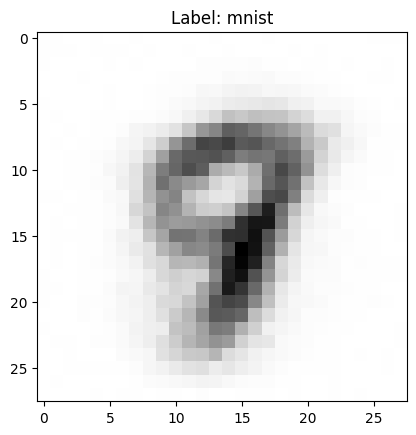

In [23]:
# random z

z=torch.randn(25,z_dim).to(device)
decoder_x=ed_model.decoder(z)

decoder_x.shape
g_x=decoder_x.reshape(-1,1,28,28).data.cpu().detach() # generator image
save_image(g_x,"image/test.png",normalize=True,nrow=5)

for i in range(5):
    show_mnist_image(g_x[i][0], "mnist")

# 8 save model

In [ ]:
os.makedirs("model",exist_ok=True)
torch.save(ed_model.decoder.state_dict(),"model/mnist_vae_model.pth")

# 9 load model

In [25]:
# load and use model
new_model=Decoder(z_dim).to(device)
new_model.load_state_dict(torch.load("model/mnist_vae_model.pth"))

<All keys matched successfully>

# 10 use new model

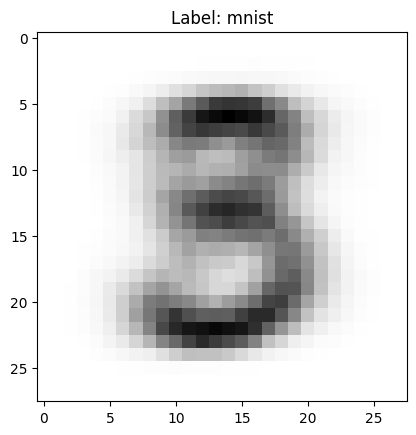

In [26]:
z=torch.randn(25,z_dim).to(device)

g_x=new_model(z).reshape(-1,1,28,28).data.cpu().detach() # generator image
save_image(g_x,"image/test.png",normalize=True,nrow=5)

for i in range(5):
    show_mnist_image(g_x[i][0], "mnist")